<a href="https://colab.research.google.com/github/allicodi/bsta001_final/blob/main/BSTA_001_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Face Mask Mandates on COVID-19 Case Incidence
---


**Nora Abbott, Allison Codi**

**BSTA 001 Final Project**

**Fall 2020**

## Summary



In the COVID-19 pandemic, public health efforts have been of utmost importance in mitigating spread of the virus. In the United States, states have taken steps to reduce the spread of the virus on an individual basis with lack of unity on policy implementation. The differences in public health regulations have led to variability in case incidence on a state by state level. The goal of this paper is to examine how policy differences in the enforcement of mask mandates impact the incidence of COVID-19 cases on a state by state level. With data from The COVID Tracking Project and the Inter-university Consortium for Political and Social Research, we used chi-squared, paired t-test, and linear regression analysis to determine if the implementation of strict mask wearing policies lowers COVID-19 case incidence. We did not find a significant difference in case incidence between states with and without face masks mandates, nor did we find a significant difference when that mandate was accompanied by a fine or citation. 


## Data

This exploratory data analysis combined two online data sets: The COVID Tracking Project’s ‘All State History’ data set and a COVID-19 US State Policy policy dataset from the Inter-university Consortium for Political and Social Research. 


For this analysis, the COVID incidence values were extracted from The COVID Tracking Project, run by journalists at The Atlantic. This dataset is available as a csv, api, or json at https://covidtracking.com/data/download. The project was originally created to inform the United States public with accurate data on COVID-19 cases, as well as to combat a lag in testing results that prevented information from reaching the public in a timely manner. This dataset is updated daily by volunteers at The Atlantic. Each day, these individuals retrieve COVID-19 case information manually and cross-check the data to ensure accuracy. This method is different from many other major COVID-19 trackers that automatically retrieve information from the internet without ensuring its accuracy. The data used in this project is mainly taken from records published by individual states. In addition, The COVID Tracking Project uses case data that may not be available or easily accessible to the public. Because this dataset only includes data that “comes from state and territory public health authorities or official statements from state officials,”  it is important to understand that the more recent data may not be accurate because states tend to backlog data (The COVID Tracking Project). The tendency to backfill data may affect the accuracy of the results in this project, however, because the most recent reported face mask mandate was in August, this is likely to have little effect. The COVID Tracker provides many relevant variables including case rates, tests given, deaths, and more, however, for this project, only increases in positive cases (positiveIncrease) was extracted.

[The COVID-19 US State Policy Database](https://www.openicpsr.org/openicpsr/project/119446/version/V37/view?path=/openicpsr/119446/fcr:versions/V37/COVID-19-US-State-Policy-Database-master/COVID-19-US-state-policy-database-10_19_2020.xlsx&type=file) was used to obtain data about mask mandates across the country. The database is created and maintained by a team of researchers in the Inter-university Consortium for Political and Social research. Although our research focused on policies regarding mask mandates, the database also includes information on business closures, state of emergency declarations, school closures, mandated quarantine from visitation outside the state, and many other policy implementations or lack thereof. In order for a policy to be included in the database, it must apply to the entire state and be a directive or mandate, not a guidance or recommendation. Data was collected from state government websites and official press releases. The data sources used in the database are compiled in a [DropBox folder](http://tinyurl.com/statepolicysources) listed on the data source web page.

To narrow down the dataset to focus on policies that impact mask mandates, we chose to focus on three attributes: FM_ALL, FMCITE, and FMFINE. FM_ALL represents the date each state implemented a mandate for face masks to be worn in all public spaces. Based on this attribute, we were able to calculate the change in case incidence before and after the policy was put into place. FMCITE is a binary variable representing if wearing a face mask is enforced by criminal charge or citation. Similarly, FMFINE is a binary variable representing if wearing a face mask is enforced by fine. These variables are not mutually exclusive, as some states implemented both fines and citations to citizens who did not comply with mask mandates. 


### Data Cleaning


Before beginning our statistical analysis, we had to clean the two data sets and extract the necessary variables.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import datetime
import seaborn as sns

Mounted at /content/drive


In [ ]:
caseData = pd.read_csv('https://covidtracking.com/data/download/all-states-history.csv')

In [ ]:
policyData_raw = pd.read_csv('/content/drive/My Drive/COVID-19_policy.csv') #change per person
# /content/drive/My Drive/BSTA001/covid_policy_data_11_3_2020.csv #for alli
# /content/drive/My Drive/COVID-19_policy.csv # for nora
policyData = policyData_raw[4:55] #the postcodes (state Abbrev) are not alphabetical

In [ ]:
policyData.head()

,STATE,POSTCODE,FIPS,STEMERG,CLSCHOOL,CLDAYCR,OPNCLDCR,CLNURSHM,STAYHOME,STAYHOMENOGP,END_STHM,CLBSNS,END_BSNS,RELIGEX,FM_ALL,FMFINE,FMCITE,FMNOENF,FM_EMP,FM_END,FM_STP,ALCOPEN,ALCREST,ALCDELIV,GUNOPEN,CLREST,ENDREST,RSTOUTDR,CLGYM,ENDGYM,CLMOVIE,END_MOV,CLOSEBAR,END_BRS,END_HAIR,END_RELG,ENDRETL,BCLBAR2,CLBAR2,CLMV2,...,UICLDCR,UIEXTND,UIMAXAMT,UIMAXEXT,UIMAXDUR,UIMAXCAR,UIMINBP,UIQTRNEED,UIOUTHQBP,UIREQBPL2Q,UIBPEARN300,UITAXWA,UIMINTAXR,UIMAXTAXR,UIAVGBFTAUG,LMABRN,TLHlBUPR,EXTOPFL,HMDLVOP,TLHLCL24,EXCEMORP,WVDEAREQ,PDSKLV,MEDEXP,POPDEN18,POP18,SQML,HMLS19,UNEMP18,POV18,RISKCOV,DEATH18,MH19,VBMEXC,VBMSIG,VBMPERM,VBMAUTOBAL,VBMAUTOAP,VBMGENELEC,Unnamed: 162
4,Alabama,AL,1,3/13/20,3/20/20,3/20/20,5/23/20,3/19/20,4/4/20,0,4/30/20,3/28/20,4/30/20,0,7/16/20,0,0,1,5/11/20,0,0,1,3/24/20,3/24/20,1,3/19/20,5/11/20,0,3/28/20,5/11/20,3/28/20,5/22/20,3/19/20,5/11/20,5/11/20,5/11/20,4/30/20,0,0,0,...,0,0,275,875,20,39,2340,2,780,0,Max Benefit < $300,8000,0.65,6.8,$250.77,1,0,0,0,3/20/20,0,0,0,0,93.24,4887871,52420,"3,261",5.6,16.8,43.1,"54,352",100.7,0,1,0,0,0,10/29/20,NaN
5,Alaska,AK,2,3/11/20,3/16/20,0,0,0,3/28/20,0,4/24/20,3/24/20,4/24/20,0,4/24/20,1,1,0,4/24/20,5/22/20,0,1,3/17/20,3/17/20,1,3/18/20,4/24/20,0,3/18/20,5/8/20,3/18/20,5/8/20,3/18/20,5/8/20,4/24/20,5/8/20,4/24/20,0,0,0,...,1,0,370,970,26,39,2500,2,250,0,13636.36,41500,1,5.4,$443.23,1,0,0,0,0,0,0,0,1,1.11,737438,665384,"1,907",6.8,10.9,32.8,"4,453",429.9,0,1,0,0,2,10/24/20,NaN
6,Arizona,AZ,4,3/11/20,3/16/20,0,0,0,3/31/20,0,5/16/20,3/31/20,5/8/20,1,0,0,0,0,5/8/20,0,3/30/20,1,3/19/20,3/19/20,1,3/21/20,5/11/20,0,3/21/20,5/13/20,3/21/20,5/16/20,3/21/20,5/16/20,5/8/20,0,5/8/20,6/29/20,6/29/20,6/29/20,...,1,0,240,840,26,39,7020,2,2340,0,Max Benefit < $300,7000,0.05,12.85,$237.99,0,0,0,0,0,3/11/20,0,1,1,62.91,7171646,113990,"10,007",5.4,14,39.1,"59,282",132.9,0,0,0,0,0,10/23/20,NaN
7,Arkansas,AR,5,3/11/20,3/17/20,0,0,3/13/20,0,0,0,4/6/20,5/4/20,0,7/20/20,1,1,0,5/11/20,0,0,1,3/19/20,3/19/20,1,3/20/20,5/11/20,0,3/20/20,5/4/20,3/20/20,5/18/20,3/20/20,5/19/20,5/6/20,0,5/18/20,0,0,0,...,0,0,451,1051,16,33,2835,2,1,0,31200,7000,0.1,6,$223.84,1,0,0,0,0,0,0,0,1,56.67,3013825,53179,"2,717",4.5,17.2,43.5,"32,336",231.6,0,0,0,0,0,10/27/20,NaN
8,California,CA,6,3/4/20,3/23/20,0,0,0,3/19/20,0,0,3/19/20,5/8/20,0,6/18/20,0,0,1,5/5/20,0,0,1,3/19/20,3/19/20,0,3/16/20,5/18/20,0,3/19/20,0,3/19/20,0,3/16/20,0,8/28/20,5/25/20,5/8/20,0,0,7/13/20,...,0,0,450,1050,26,39,1125,2,225,0,6900,7000,1.5,6.2,$282.35,0,0,0,0,0,0,0,1,1,241.65,39557045,163695,"151,278",5.5,12.8,33.3,"268,818",356.2,0,0,0,1,0,0,NaN


In [ ]:
caseData.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2020-12-14,AK,A,176.0,176.0,0,NaN,889.0,889.0,140.0,3,NaN,NaN,1107400.0,4040,NaN,NaN,1098479.0,NaN,12.0,40160.0,NaN,422,0,NaN,NaN,NaN,NaN,47796.0,7165.0,NaN,0,1147560.0,4462,NaN,NaN,NaN,NaN,NaN,0,1147560.0,4462
1,2020-12-14,AL,A,4102.0,3624.0,0,478.0,28913.0,28913.0,2286.0,767,2363.0,NaN,1478907.0,20347,NaN,NaN,NaN,1353.0,NaN,297895.0,244762.0,2264,0,NaN,NaN,NaN,NaN,NaN,174805.0,NaN,0,1723669.0,27230,NaN,NaN,78262.0,NaN,1723669.0,27230,NaN,0
2,2020-12-14,AR,A+,2990.0,2656.0,45,334.0,9991.0,9991.0,1050.0,64,NaN,372.0,1705843.0,9262,NaN,NaN,1705843.0,1095.0,180.0,187507.0,160356.0,1805,0,NaN,3300.0,NaN,32616.0,NaN,163351.0,NaN,0,1866199.0,10495,NaN,21856.0,NaN,179158.0,NaN,0,1866199.0,10495
3,2020-12-14,AS,D,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,2140.0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2020-12-14,AZ,A+,7358.0,6782.0,1,576.0,31142.0,31142.0,3677.0,193,NaN,829.0,2126928.0,7223,NaN,NaN,NaN,NaN,542.0,420248.0,404294.0,11806,0,NaN,NaN,NaN,NaN,NaN,62118.0,NaN,0,4344693.0,38805,377958.0,NaN,NaN,NaN,2531222.0,18526,4344693.0,38805


In [ ]:
caseData['date'] = caseData['date'].astype('datetime64[ns]') #converts date attribute from string type to datetime type to be used for calculations

#gather dates of face mask mandates and their respective states
dateOfFM = policyData.FM_ALL #date of implemetation for fask mask mandates
stateOfFM = policyData.POSTCODE #state abbreviations
citeYN = policyData.FMCITE #whether or not a state gives citations for not wearing a fask mask
fineYN = policyData.FMFINE #whether or not a state has a fine for not wearing a fask mask

dateOfFM = pd.to_datetime(dateOfFM, errors = 'coerce') #converts date face mask mandate implemented from string type to datetime type to be used for calculations

In [ ]:
caseData.info() #look at types and verify datetime conversion worked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16082 entries, 0 to 16081
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              16082 non-null  datetime64[ns]
 1   state                             16082 non-null  object        
 2   dataQualityGrade                  14820 non-null  object        
 3   death                             15255 non-null  float64       
 4   deathConfirmed                    6977 non-null   float64       
 5   deathIncrease                     16082 non-null  int64         
 6   deathProbable                     5332 non-null   float64       
 7   hospitalized                      9738 non-null   float64       
 8   hospitalizedCumulative            9738 non-null   float64       
 9   hospitalizedCurrently             12940 non-null  float64       
 10  hospitalizedIncrease              16082 non-nu

In [ ]:
#keeping only necessary columns

dataUnclean = caseData[['date', 'state', 'positiveIncrease']] #making dataset of only necessary case data
dataUnclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16082 entries, 0 to 16081
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              16082 non-null  datetime64[ns]
 1   state             16082 non-null  object        
 2   positiveIncrease  16082 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 377.0+ KB


In [ ]:
dataFinal = dataUnclean[~(dataUnclean['positiveIncrease'] <= 0)]  #remove all positive increase data less than 0, assumed errors in dataset

## Methods


### Cases over Time Plot

We created a visualization of COVID-19 cases over time by state from the start of the pandemic until present day.

In [ ]:
FMdf = pd.DataFrame({'FM_ALL':dateOfFM, 'State':stateOfFM}) #making data frame of face mask mandates

for col in FMdf.columns: #checking column titles
  print(col)

FMdf = FMdf.dropna(axis=0) #remove all states with FM_ALL = NaT

print(FMdf)

FM_ALL
State
       FM_ALL State
4  2020-07-16    AL
5  2020-04-24    AK
7  2020-07-20    AR
8  2020-06-18    CA
9  2020-07-16    CO
10 2020-04-20    CT
11 2020-04-28    DE
12 2020-04-17    DC
15 2020-04-16    HI
17 2020-05-01    IL
18 2020-07-27    IN
20 2020-07-03    KS
21 2020-05-11    KY
23 2020-05-01    ME
24 2020-04-18    MD
25 2020-05-06    MA
26 2020-04-27    MI
27 2020-07-24    MN
28 2020-08-05    MS
32 2020-06-26    NV
34 2020-04-08    NJ
35 2020-05-15    NM
36 2020-04-17    NY
37 2020-06-26    NC
39 2020-07-23    OH
41 2020-07-01    OR
42 2020-07-01    PA
43 2020-04-18    RI
47 2020-07-03    TX
48 2020-04-10    UT
49 2020-08-01    VT
50 2020-05-29    VA
51 2020-06-26    WA
52 2020-07-07    WV
53 2020-08-01    WI


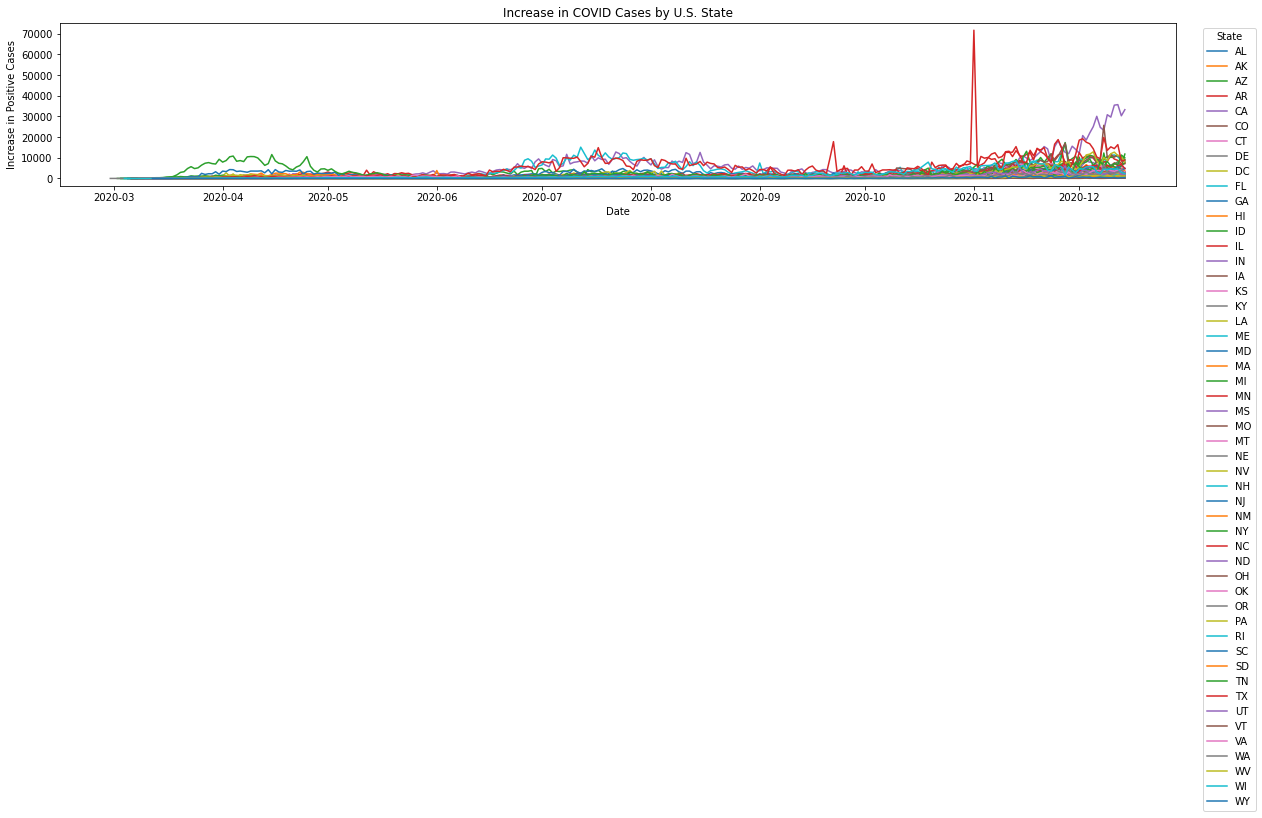

In [ ]:
fig, ax = plt.subplots(figsize=(20,3))

casesByState = []

stateAbbrev = policyData.POSTCODE #all state abbreviation

for state in stateAbbrev: # for loop for separating case data by state
  stateCases = dataFinal.loc[dataFinal['state'] == state] 
  casesByState.append(stateCases)
  #graph of state case increases over time
  x = stateCases.date
  y = stateCases.positiveIncrease
  ax.plot(x, y, label=state)

ax.set_title('Increase in COVID Cases by U.S. State')
ax.set_xlabel('Date')
ax.set_ylabel('Increase in Positive Cases')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='State')
plt.show()

### Graphical Analysis of Fask Mask Mandates

We also created an initial visualization of COVID-19 cases before and after the implementation of a mask mandate on a state by state basis. States without a mask mandate were excluded from the visualization. 

In [ ]:
beforeDate = []
afterDateBegin = []
afterDateEnd = []

for date in FMdf.FM_ALL:  #calculate two week periods before and after mandate implementation
  beforeDate.append(date - datetime.timedelta(days=14))
  afterDateBegin.append(date + datetime.timedelta(days=14)) #two week gap after policy implementation, then average taken over next two week period
  afterDateEnd.append(date + datetime.timedelta(days=28))

  
FMdf['TwoWksBefore'] = beforeDate
FMdf['TwoWksAfter'] = afterDateBegin
FMdf['FourWksAfter'] = afterDateEnd

FMdf.head()  

,FM_ALL,State,TwoWksBefore,TwoWksAfter,FourWksAfter
4,2020-07-16,AL,2020-07-02,2020-07-30,2020-08-13
5,2020-04-24,AK,2020-04-10,2020-05-08,2020-05-22
7,2020-07-20,AR,2020-07-06,2020-08-03,2020-08-17
8,2020-06-18,CA,2020-06-04,2020-07-02,2020-07-16
9,2020-07-16,CO,2020-07-02,2020-07-30,2020-08-13


In [ ]:
avgCasesBefore = []
avgCasesAfter = []

for i in FMdf.index: #cycle through all states and calculate avg increase over time frame
  positiveIncrease = []
  state = FMdf['State'][i] # get state at index
  data = dataFinal.loc[dataFinal['state'] == state] #get policy data associated with state
  
  before = data.loc[(data.date>=FMdf['TwoWksBefore'][i]) & (data.date<=FMdf['FM_ALL'][i]),:].positiveIncrease #data from two week period before policy implemented
  after = data.loc[(data.date >= FMdf['TwoWksAfter'][i]) & (data.date<=FMdf['FourWksAfter'][i]),:].positiveIncrease #data from two week period after policy implemented
  
  avgCasesBefore.append(np.mean(before)) #calc averages
  avgCasesAfter.append(np.mean(after))

FMdf['avgCasesBefore'] = avgCasesBefore #add list of averages to the dataframe
FMdf['avgCasesAfter'] = avgCasesAfter

In [ ]:
FMdf.head()

,FM_ALL,State,TwoWksBefore,TwoWksAfter,FourWksAfter,avgCasesBefore,avgCasesAfter
4,2020-07-16,AL,2020-07-02,2020-07-30,2020-08-13,1475.066667,1451.666667
5,2020-04-24,AK,2020-04-10,2020-05-08,2020-05-22,6.933333,2.461538
7,2020-07-20,AR,2020-07-06,2020-08-03,2020-08-17,893.166667,792.615385
8,2020-06-18,CA,2020-06-04,2020-07-02,2020-07-16,2894.133333,8002.600000
9,2020-07-16,CO,2020-07-02,2020-07-30,2020-08-13,379.800000,428.200000


In [ ]:
statesWithPolicies = [FMdf['State'][i] for i in FMdf.index if str(FMdf['FM_ALL'][i]) != 'NaT'] #might use this to eliminate states w/o policy from graph below, still have to implement
print(statesWithPolicies)
len(statesWithPolicies)

['AL', 'AK', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'IN', 'KS', 'KY', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OR', 'PA', 'RI', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI']


35

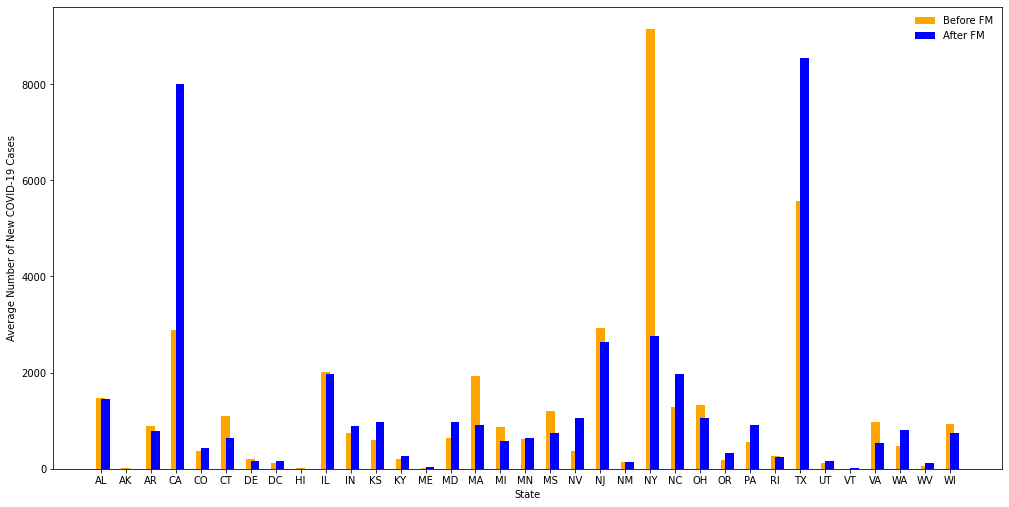

In [ ]:
#plot data
from matplotlib.pyplot import figure

width = 0.35  #width of bars

fig, ax = plt.subplots()
rects1 = ax.bar(FMdf.State, FMdf.avgCasesBefore, width, align= 'center', color='orange', label='Before FM')
rects2 = ax.bar(FMdf.State, FMdf.avgCasesAfter, width, align= 'edge', color='blue', label='After FM')
ax.set_ylabel('Average Number of New COVID-19 Cases')
ax.set_xlabel('State')
ax.set_xticklabels(FMdf.State)
ax.legend(frameon=False)
fig.set_size_inches(17, 8.5, forward=True)

In this analysis, three main statistical tools were used: The Chi Square Test, Paired-t Hypothesis Testing, and Simple Linear Regression. All three of these tests compared a ‘Before’ period, or the two-week period before a state’s fask mask policy was enacted, and an ‘After’ period, or a two week period following a pause of two weeks after the mandate enactment date. This time period design was used for each of the three statistical tools. In all three statistical tests the difference in average number of cases before and after the fask mask mandate, with or without a fine and/or citation, was used as a main variable. The ‘difference’ value was calculated using the following formula:
 $Difference = \overline{ Cases after mandate} - \overline{Cases before mandate}$ 
 
 If the difference value for a state was positive, this would suggest that the case experienced a rise in cases after the policy. If the value is negative, there was a decrease in cases in the period after the mandate.

### Chi Square Test and 2x2 Tables

The Chi Square tests were used to compare whether or not a state saw an increase or decrease in the average number of COVID-19 cases after a fask mandate was implemented. The first Chi Square test investigated the relationship between states with fask mask mandates that included a fine for noncompliance and whether or not that policy resulted in a decrease in average case incidence. Similarly, the second Chi Square test analyzed whether cases saw a decrease in average case incidence after a fask mask policy with a citation for noncompliance was implemented. For both Chi Square tests, if a state had a fine or citation policy associated with their face mask mandate, they were given a 1 value, and a 0 if these criteria were not met. Additionally, the ‘difference’ variable was changed to a binary form, where a positive ‘difference’ value was denoted with a 0, while a negative ‘difference’ value was given a 1.  In these tests, the significance level selected for this test was ⍺ = 0.05, or 95% confidence.


Chi Square Tests

$\alpha = 0.05$

$ H_0 : \chi^2 = 0$

$ H_A : \chi^2 \neq 0$

In [ ]:
#prepare dataframes for rate and citation (0/1) and rate and fine(0/1)
rateDifference = []
print(FMdf.index)

#organize decreases and increases in avg case incidence before and after FM mandate
for i in FMdf.index: 
  before = FMdf['avgCasesBefore'][i] 
  after = FMdf['avgCasesAfter'][i]
  diff = after - before
  if diff < 0:
    rateDifference.append(1) #mask mandate worked
  else:
    rateDifference.append(0) #mandate didnt work
#print(len(rateDifference))
#print(rateDifference)

Int64Index([ 4,  5,  7,  8,  9, 10, 11, 12, 15, 17, 18, 20, 21, 23, 24, 25, 26,
            27, 28, 32, 34, 35, 36, 37, 39, 41, 42, 43, 47, 48, 49, 50, 51, 52,
            53],
           dtype='int64')


In [ ]:
policyDataClean = pd.DataFrame({'FM_ALL':dateOfFM, 'State':stateOfFM, 'FMFINE':fineYN, 'FMCITE':citeYN}) #making data frame for easy cleaning of NaT
policyDataClean = policyDataClean.dropna(axis=0) #remove all states w/ FM_ALL = NaT for matching equal column lengths
#print(len(policyDataClean))

fine = policyDataClean.FMFINE
cite = policyDataClean.FMCITE

#print(len(fine))
#print(len(cite))
ratesAndFine= pd.DataFrame({'rate diff':rateDifference, 'fine':fine})
ratesAndCite = pd.DataFrame({'rate diff':rateDifference, 'cite':cite})

In [ ]:
# manual 2x2 chi square test for rate vs fine, note: matches function in next cell

#define variables
DecRYFine = 0 #decrease rate, yes fine
IncRYFine = 0 #increase rate, yes fine
DecRNFine = 0 #decrease rate, no fine
IncRNFine = 0 #increase rate, no fine

#count number observations in each 2x2 variable
for i in ratesAndFine.index:

  R = ratesAndFine['rate diff'][i] 
  F = ratesAndFine['fine'][i] 

  if R == 1 and F == "1":
    DecRYFine += 1
  if R == 0 and F == "1":
    IncRYFine += 1
  if R == 1 and F == "0":
    DecRNFine += 1
  if R == 0 and F == "0":
    IncRNFine += 1

#print(DecRYFine)
#print(IncRYFine)
#print(DecRNFine)
#print(IncRNFine)

#sum of var
allI = IncRYFine + IncRNFine #all observed increases in rate
allD = DecRYFine + DecRNFine #all observed decreases in rate
allY = DecRYFine + IncRYFine #all observed yes fines
allN = DecRNFine + IncRNFine #all observed no fines
all = len(ratesAndFine) #all observed
#print(all)

#probs
probI = allI / all
probD = allD / all
probY = allY / all
probN = allN / all

#expected values
ExDecRYFine = probD * probY *all
ExIncRYFine = probI * probY *all
ExDecRNFine = probD * probN *all
ExIncRNFine = probI * probN *all

#print(DecRYFine)
#print(ExDecRYFine)

#Goodness of fit
gFitDecRYFine = (DecRYFine - ExDecRYFine)**2 / ExDecRYFine
gFitIncRYFine = (IncRYFine - ExIncRYFine)**2 / ExIncRYFine
gFitDecRNFine = (DecRNFine - ExDecRNFine)**2 / ExDecRNFine
gFitIncRNFine = (IncRNFine - ExIncRNFine)**2 / ExIncRNFine

#calc chi square test stat
chiTestStat = gFitDecRYFine + gFitIncRYFine + gFitDecRNFine + gFitIncRNFine

print("Chisqares test statistic = {:.3f}".format(chiTestStat))

Chisqares test statistic = 1.373


In [ ]:
# Crosstab function for chi square 2x2 rate vs fine

O1 = pd.crosstab(index=ratesAndFine["rate diff"]       # the rows (index)
                ,columns=ratesAndFine["fine"]) # the columns (columns) #build 2x2 table for rate increase(0)/decrease(1) and fine (0/1)
print(O1)

from scipy.stats import chi2_contingency
testStat, pvalue,df,E = scipy.stats.chi2_contingency(O1)
print("Chisqares test statistic (w/ Yates' correction)= {:.2f}".format(testStat)) #print chi square test stat w/ Yates' correction
print("Pvalue = {:.3f}".format(pvalue)) #print correspond p value

fine        0  1
rate diff       
0          12  6
1           8  9
Chisqares test statistic (w/ Yates' correction)= 0.69
Pvalue = 0.407


$p > .05$

Fail to Reject the Null Hypothesis

Therefore, no significant difference


In [ ]:
# manual 2x2 chi square test for rate vs citation, note: matches function in next cell

#define variables
DecRYCite = 0 #decrease rate, yes cite
IncRYCite = 0 #increase rate, yes cite
DecRNCite = 0 #decrease rate, no cite
IncRNCite = 0 #increase rate, no cite

#count number observations in each 2x2 variable
for i in ratesAndCite.index:

  R = ratesAndCite['rate diff'][i] 
  C = ratesAndCite['cite'][i] 

  if R == 1 and C == "1":
    DecRYCite += 1
  if R == 0 and C == "1":
    IncRYCite += 1
  if R == 1 and C == "0":
    DecRNCite += 1
  if R == 0 and C == "0":
    IncRNCite += 1

#sum of var 
allI2 = IncRYCite + IncRNCite
allD2 = DecRYCite + DecRNCite
allC = DecRYCite + IncRYCite
allN2 = DecRNCite + IncRNCite
all2 = len(ratesAndCite)

#probabilities
probI2 = allI2 / all2
probD2 = allD2 / all2
probC = allC / all2
probN2 = allN2 / all2

#expected values
ExDecRYCite = probD2 * probC *all2
ExIncRYCite = probI2 * probC *all2
ExDecRNCite = probD2 * probN2 *all2
ExIncRNCite = probI2 * probN2 *all2

#Goodness of fit
gFitDecRYCite = (DecRYCite - ExDecRYCite)**2 / ExDecRYCite
gFitIncRYCite = (IncRYCite - ExIncRYCite)**2 / ExIncRYCite
gFitDecRNCite = (DecRNCite - ExDecRNCite)**2 / ExDecRNCite
gFitIncRNCite = (IncRNCite - ExIncRNCite)**2 / ExIncRNCite

#calc chi square test stat
chiTestStat2 = gFitDecRYCite + gFitIncRYCite + gFitDecRNCite + gFitIncRNCite

print("Chisqares test statistic = {:.3f}".format(chiTestStat2))

Chisqares test statistic = 1.457


In [ ]:
# Crosstab function for chi square 2x2 rate vs citation

O2 = pd.crosstab(index=ratesAndCite["rate diff"]  
                ,columns=ratesAndCite["cite"]) #build 2x2 table for rate increase(0)/decrease(1) and citation (0/1)
print(O2) 

testStat, pvalue,df,E = scipy.stats.chi2_contingency(O2)
print("Chisqares test statistic (w/ Yates' correction)= {:.2f}".format(testStat)) #print chi square test stat w/ Yates' correction
print("Pvalue = {:.3f}".format(pvalue)) #print correspond p value

cite        0  1
rate diff       
0          14  4
1          10  7
Chisqares test statistic (w/ Yates' correction)= 0.71
Pvalue = 0.399


$p > .05$ 

Fail to reject null hypothesis

Therefore, no significant difference

### Paired T-test

The second statistical tool used was a hypothesis test, specifically a paired-t test. The ‘difference’ variable defined above was used in this tool as well. The null hypothesis ($H_0$) was that the difference in the average number of cases before and after the fask mask mandate was zero. The alternative hypothesis ($H_A$) was that the difference in the average number of cases before and after the fask mask mandate was less than zero. This was a one sided paired t-test with a significance level of 0.05, or 95% confidence. 


$\alpha = 0.05$

$ H_0 : \mu_a - \mu_b = 0$ (policy does not impact average increase in cases)

$ H_A : \mu_a - \mu_b < 0$ (policy decreases average increase in cases)

In [ ]:
changeCaseIncidence = [] #list of case incidence differences before and after face mask mandate

for i in FMdf.index: 
  before = FMdf['avgCasesBefore'][i] 
  after = FMdf['avgCasesAfter'][i]
  diff = after - before
  changeCaseIncidence.append(diff)

meanChangeCaseIncidence = np.mean(changeCaseIncidence) #average difference of case incidence
stDChangeCaseIncidence = np.std(changeCaseIncidence) #stD of case incidence

df = len(changeCaseIncidence) - 1 #degrees of freedome

In [ ]:
t = np.sqrt(len(changeCaseIncidence))*(meanChangeCaseIncidence - 0) / stDChangeCaseIncidence #calculate test statistic
print("T-test = {:.2f}".format(t))

pvalue = 2*(1-scipy.stats.t(len(changeCaseIncidence)-1,0,1).cdf(t)) #calculate p-value from test statistic
print("pvalue = {:.2f}".format(pvalue))

T-test = 0.15
pvalue = 0.88


$p > .05$

Fail to Reject the Null Hypothesis

Therefore, no significant difference

### Linear Regression

The third statistical tool used in this analysis was a simple linear regression. Three linear regression models were run. Each of the models compared whether or not a state met an identified condition, versus the average difference in the number of case increases before and after the mandate date. The first linear regression modeled was the relationship between face mask mandates with fines and case the case incidence difference. The second model was face mask mandates with citations versus case differences. The third, and final, model was face mask mandates with citations and fines versus case incidence differences. 

In [ ]:
policyDataClean['avgChangeIncidence'] = changeCaseIncidence #add case incidence column to clean policy data set for regression
#print(policyDataClean)
policyDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4 to 53
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FM_ALL              35 non-null     datetime64[ns]
 1   State               35 non-null     object        
 2   FMFINE              35 non-null     object        
 3   FMCITE              35 non-null     object        
 4   avgChangeIncidence  35 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.9+ KB


In [ ]:
policyDataClean['FMFINE'] = policyDataClean['FMFINE'].astype('float64') #converts date attribute from object to float64 type to be used for regression
policyDataClean['FMCITE'] = policyDataClean['FMCITE'].astype('float64') #converts date attribute from object to float64 type to be used for regression

In [ ]:
policyDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4 to 53
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FM_ALL              35 non-null     datetime64[ns]
 1   State               35 non-null     object        
 2   FMFINE              35 non-null     float64       
 3   FMCITE              35 non-null     float64       
 4   avgChangeIncidence  35 non-null     float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 2.9+ KB


No handles with labels found to put in legend.


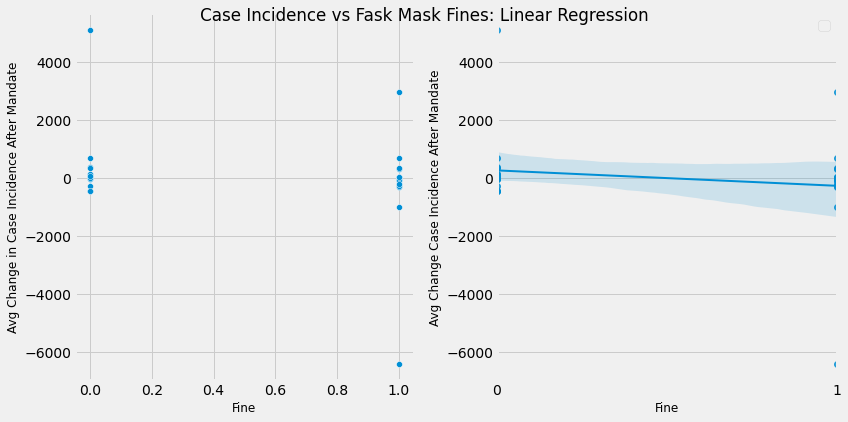

In [ ]:
#case incidence vs face mask fines ONLY
plt.style.use("fivethirtyeight")
fig,axs = plt.subplots(1,2)

ax = axs[0]
sns.scatterplot(x = "FMFINE",
                y = "avgChangeIncidence", 
                data = policyDataClean,
                ax=ax)
ax.set_xlabel("Fine", fontsize=12)
#ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change in Case Incidence After Mandate",fontsize=12)

ax=axs[1]
sns.regplot(x = "FMFINE",
            y = "avgChangeIncidence", 
            data = policyDataClean, 
            line_kws={"lw":2},
            
            )
ax.set_xlabel("Fine", fontsize=12)

ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change Case Incidence After Mandate", fontsize=12)
ax.legend()

fig.suptitle("Case Incidence vs Fask Mask Fines: Linear Regression")
fig.set_tight_layout(True)
fig.set_size_inches(12,6)

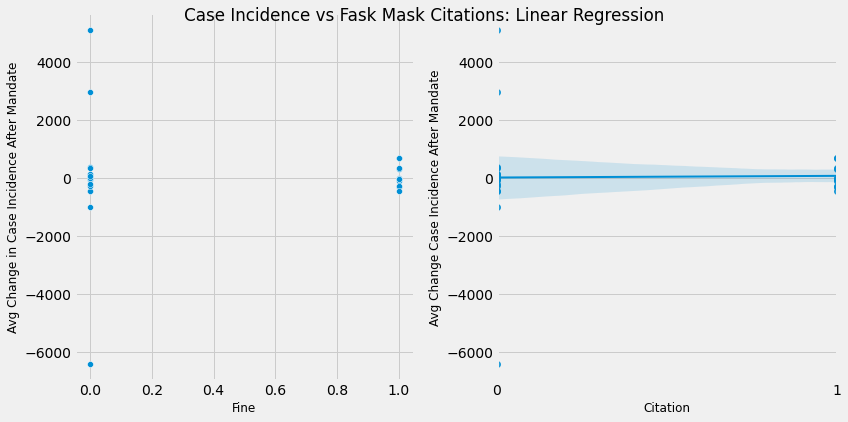

In [ ]:
#case incidence vs fask mask citations ONLY
plt.style.use("fivethirtyeight")
fig,axs = plt.subplots(1,2)

ax = axs[0]
sns.scatterplot(x = "FMCITE",
                y = "avgChangeIncidence", 
                data = policyDataClean,
                ax=ax)
ax.set_xlabel("Fine", fontsize=12)
#ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change in Case Incidence After Mandate",fontsize=12)

ax=axs[1]
sns.regplot(x = "FMCITE",
            y = "avgChangeIncidence", 
            data = policyDataClean, 
            line_kws={"lw":2},
            )
ax.set_xlabel("Citation", fontsize=12)

ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change Case Incidence After Mandate", fontsize=12)

fig.suptitle("Case Incidence vs Fask Mask Citations: Linear Regression")
fig.set_tight_layout(True)
fig.set_size_inches(12,6)

In [ ]:
bothPolicies = []

for i in policyDataClean.index:
  if ((policyDataClean['FMCITE'][i] == 1) & (policyDataClean['FMFINE'][i] == 1)): #if a state has a citation AND fine policy
    bothPolicies.append(1)
  else:
    bothPolicies.append(0) #if a state does not have both policies

policyDataClean['bothPolicies'] = bothPolicies
policyDataClean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4 to 53
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FM_ALL              35 non-null     datetime64[ns]
 1   State               35 non-null     object        
 2   FMFINE              35 non-null     float64       
 3   FMCITE              35 non-null     float64       
 4   avgChangeIncidence  35 non-null     float64       
 5   bothPolicies        35 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 3.2+ KB


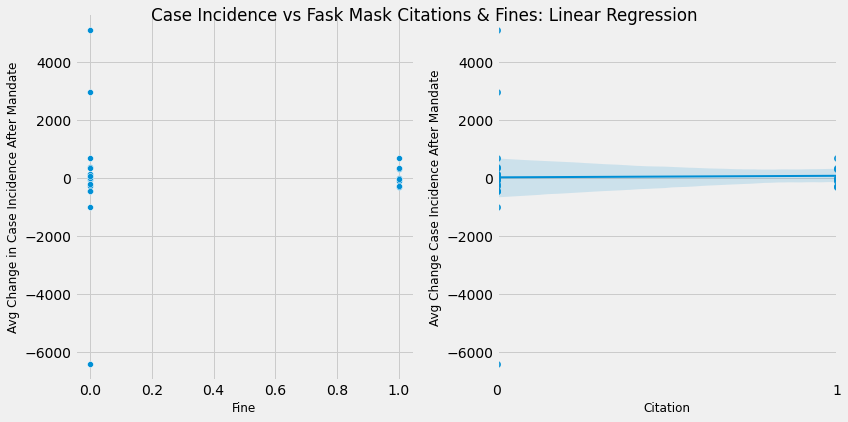

In [ ]:
#Case incidence vs Fask Mask Fine AND citations
plt.style.use("fivethirtyeight")
fig,axs = plt.subplots(1,2)

ax = axs[0]
sns.scatterplot(x = "bothPolicies",
                y = "avgChangeIncidence", 
                data = policyDataClean,
                ax=ax)
ax.set_xlabel("Fine", fontsize=12)
#ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change in Case Incidence After Mandate",fontsize=12)

ax=axs[1]
sns.regplot(x = "bothPolicies",
            y = "avgChangeIncidence", 
            data = policyDataClean, 
            line_kws={"lw":2},
            )
ax.set_xlabel("Citation", fontsize=12)

ax.set_xticks(ax.get_xticks()[::4])
ax.set_ylabel("Avg Change Case Incidence After Mandate", fontsize=12)

fig.suptitle("Case Incidence vs Fask Mask Citations & Fines: Linear Regression")
fig.set_tight_layout(True)
fig.set_size_inches(12,6)

## Results

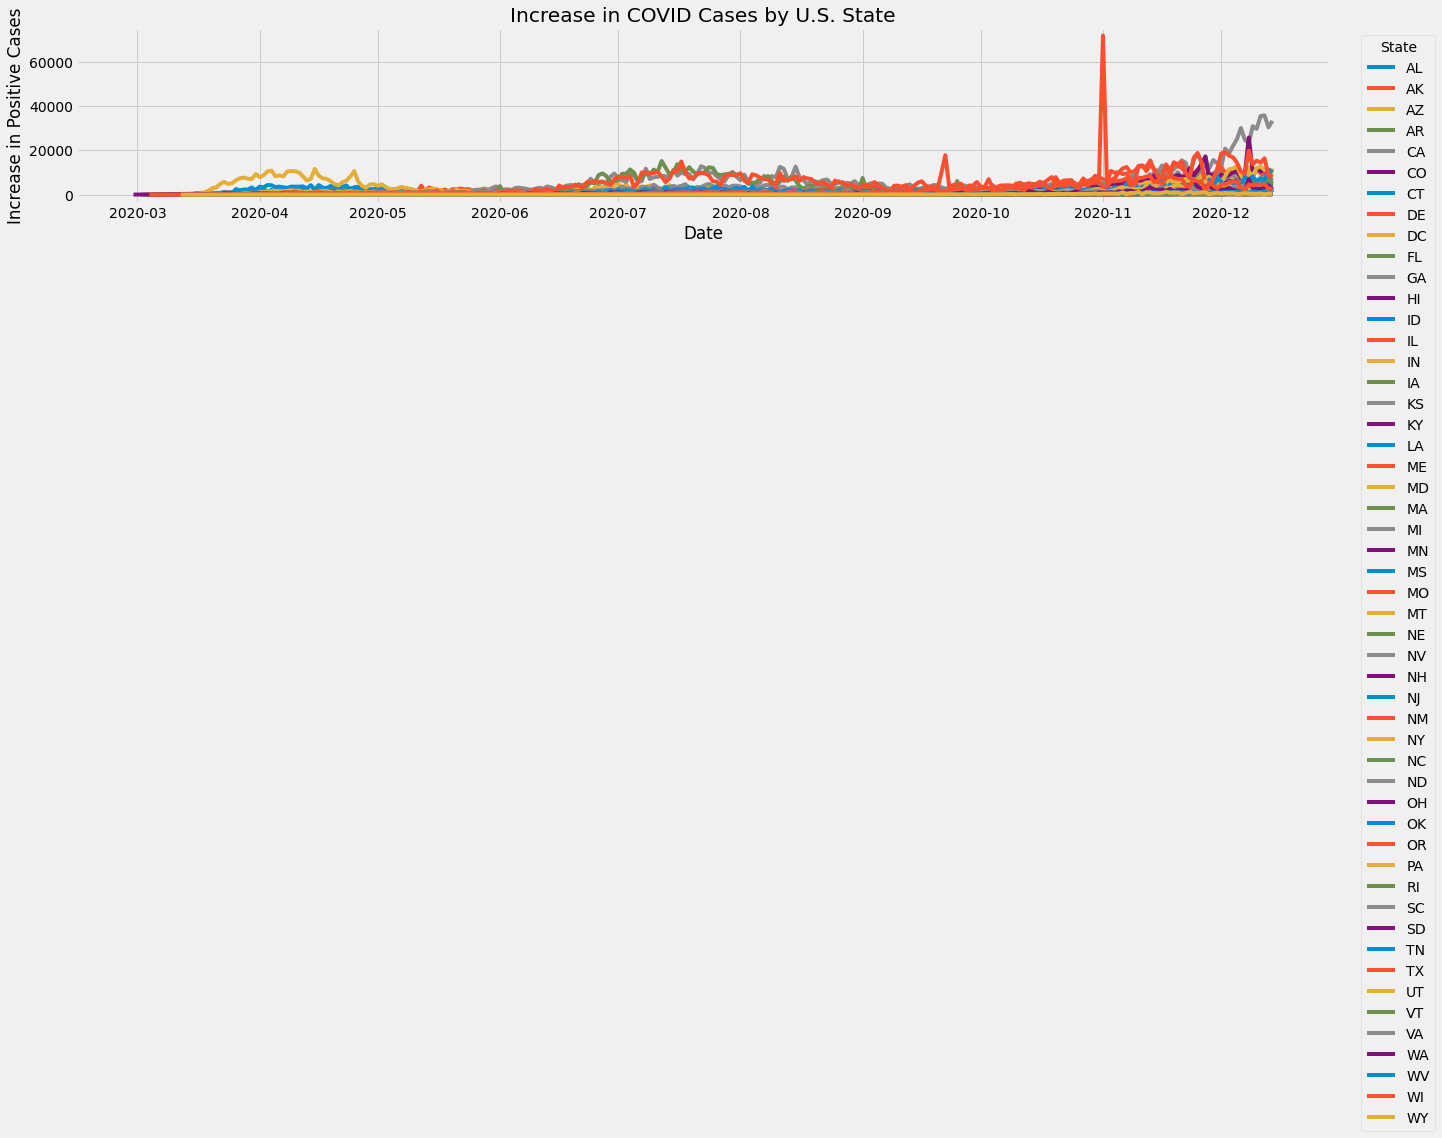 

Figure 1: Visualization of Case Incidence Over Time by State

There is a clear spike at the beginning of the pandemic with a plateau over May and June. A few states spike again in July and August with another plateau following in September and October. In late October, many states enter the largest spike seen so far in the pandemic that continues to rise in present day.

An initial visualization of our data showed mixed results for the impact of mask mandates on the incidence of COVID-19 on a state by state basis. Some states such as New York had a drastic decrease in the number of cases over the two week period after policy implementation, while others such as Texas saw a large increase in cases. 

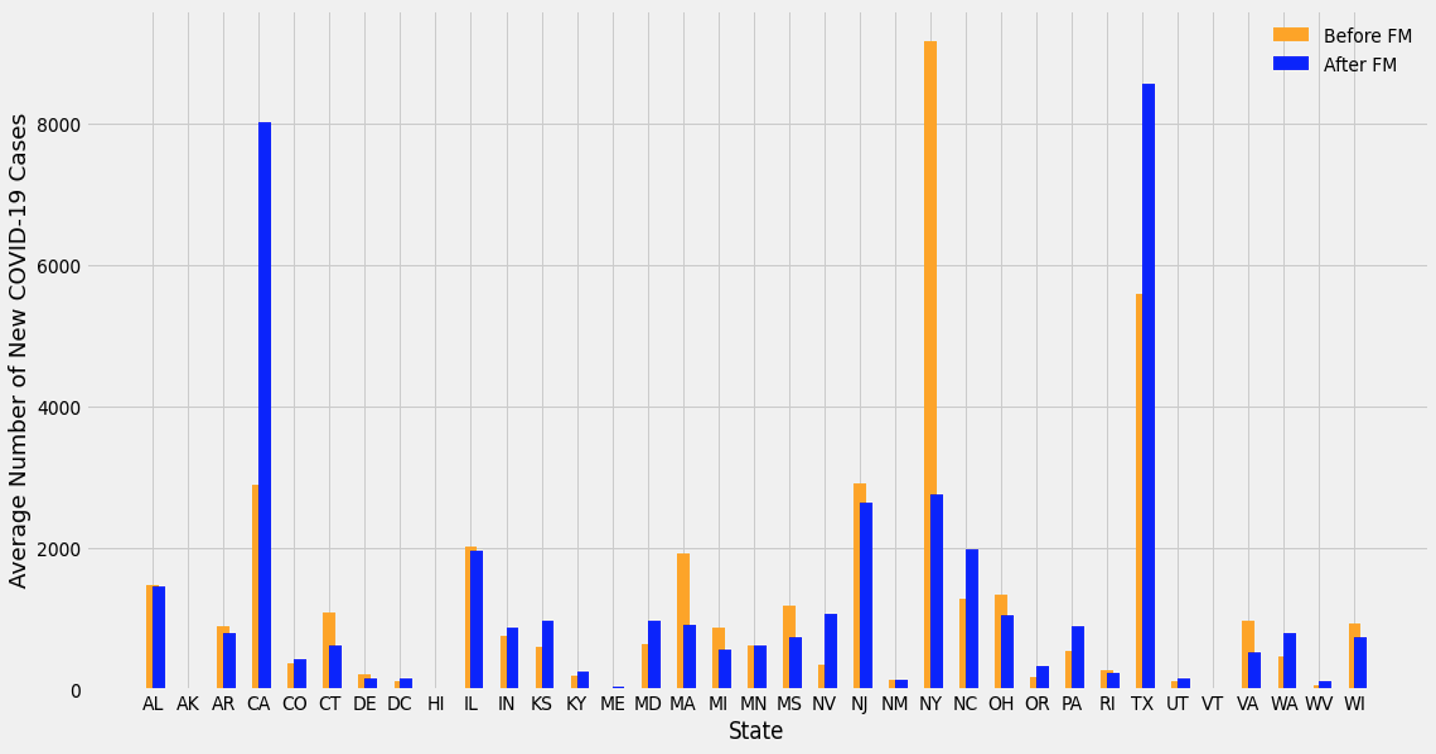
Figure 2: Average Incidence of COVID-19 Cases During Two Week Period After Mask Mandate by State

Further analysis of our data through the paired-t test yielded a p-value of 0.88. This p-value is much greater than our significance level of 0.05, so we fail to reject the null hypothesis in favor of our alternative hypothesis that mask mandates decrease the average incidence of COVID-19 cases. 



The chi-square test also failed to reject the null hypothesis for both fines and citations associated with face mask mandates. In examining the chi-square analysis for fines, a chi-square test statistic of 0.69 was obtained with a p-value of 0.407. The chi-square analysis for citations yielded a chi-square test statistic of 0.71 with a p-value of 0.399. Both of these p-values are greater than our significance level of 0.05, so neither provide significant evidence that citations and fines associated with face mask mandates cause a change in COVID-19 incidence level. Two by Two tables associated with each test are detailed in figures 3 and 4. 

In comparing the two p values, $P_{citation} > P_{fine}$ 

Therefore, there is a more significant relationship between the presence of a citation and case incidence decreasing

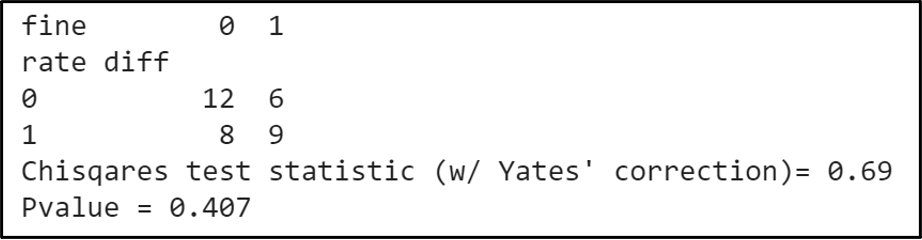

Figure 3: 2x2 Table for Chi-Square Analysis of Face Mask Fines and COVID-19 Incidence

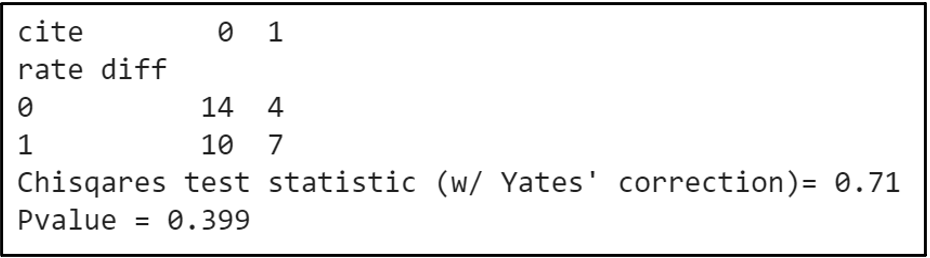

Figure 4: 2x2 Table for Chi-Square Analysis of Face Mask Citations and COVID-19 Incidence

The linear regression model showed a slight negative correlation between average case incidence and the implementation of fines for breaking mask mandates. However, there was no significant correlation between case incidence and face mask citations, nor was there correlation when looking at states which implemented both citations and fines. Plots of the linear regression models are shown in figures 5, 6, and 7.

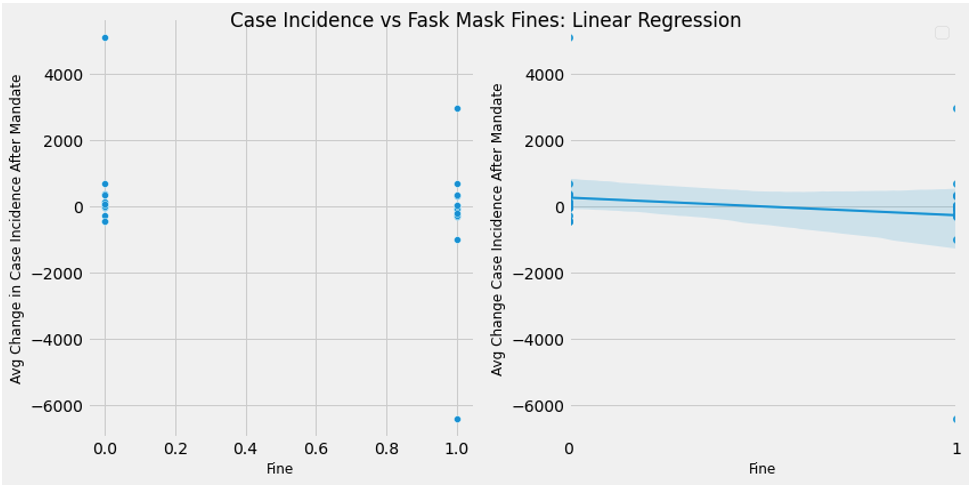
Figure 5: Linear Regression for Case Incidence vs Implementation of Fask Mask Fines


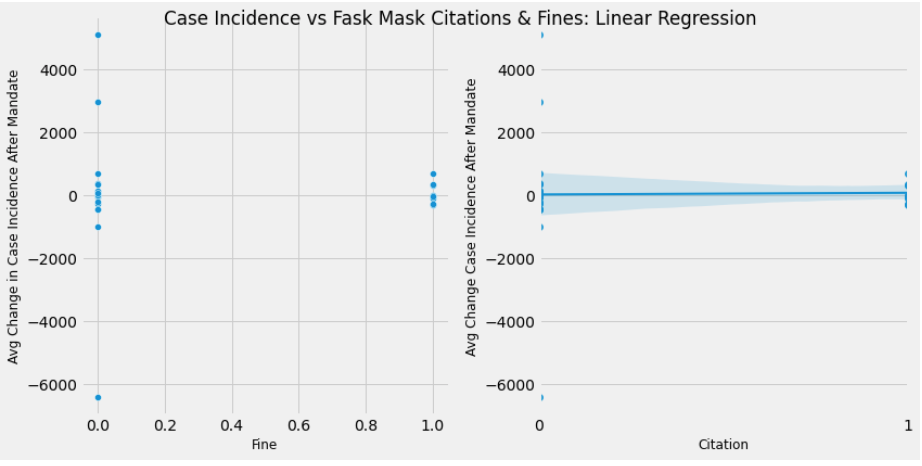

Figure 6: Linear Regression for Case Incidence vs Implementation of Fask Mask Citations

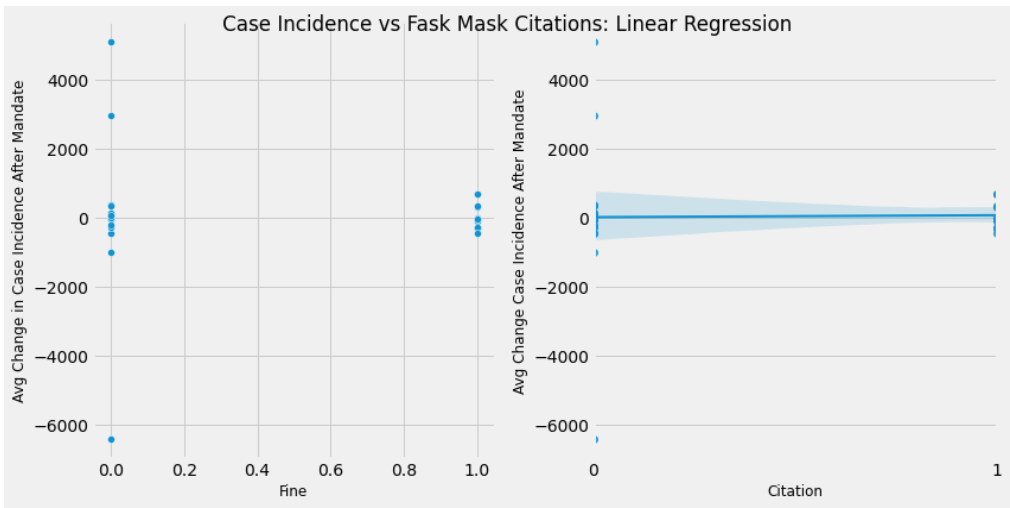
Figure 7: Linear Regression for Case Incidence vs Implementation of Both Fines and Citations for Face Mask Mandate Violations

## Discussion

In this exploratory analysis, the relationship between COVID-19 policies, specifically face mask mandates, and case incidence before and after policy enactment was explored. To do so, three statistical tools were used: a Chi Square Test, a paired-t test, and a simple linear regression. The Chi square tests for face mask mandates with fines and citations both failed to reject the null hypothesis. However, based on the analysis, the fask mask mandate with citations was slightly more likely to change COVID-19 incidence rates. The paired-t test also failed to reject the null hypothesis, with a tested p-value of $.88$, far greater than the significance level of $α=0.05$. Finally, the linear regressions for states with face mask mandates with citations and mandates with citations and fines showed no correlation. There was, however, slight negative correlation between face mask policies with fines and case incidence.

This analysis was limited by the retrieved data sets, inconstant mandate policies, and additional COVID-19 policies that were not explored. The COVID Tracking Project data set is composed of data reported by individual states. As a result, the COVID Tracking Project rates some states as having poor data quality, which leads to uncertainty of data accuracy. As a result, the results of the statistical tests with The COVID Tracker Data may not be accurate, but it is unlikely that any data set would yield completely accurate results due to testing lag and inaccurate case reporting. This analysis only reviewed the change in case values before and after the first fask mask mandate for a state. At this time, some states have repealed and reenacted fask mask policies, and their effectiveness may differ. Finally, this analysis only reviewed fask mask mandates and their relationship with COVID incidence. Other confounding factors, such as closing bars, paid time off, and state-wide quarantine, among others, were not analyzed. This analysis would be more complete if these factors were taken into account. 

Moving forward, this analysis could be improved by investigating additional factors. This could account for the likely confounding factors that have affected the case incidence rates within states. It would also be beneficial to run statistical tests that combine multiple factors, for example, fask mask mandates with fines and paid time off, to determine if combinations of policies are effective at reducing COVID incidence. To analyze multiple factors, more statistical tools could be used including Naive Bayes, K Nearest Neighbors, and the Mann-Whitney nonparametric U-test. 

A similar type of exploratory analysis is currently being performed by other research teams. A data technique called ‘differences in differences’ is used by a group of scientists to analyze the effectiveness of policies. While the analysis discussed in this report compares ‘before’ and ‘after’ periods for policies, the ‘differences in differences’ tool compares areas where policy was enacted to areas where policies were not. In the 'differences in differences' model, the areas where a policy of interest was and was not enacted are the experimental and control groups, respectively (Zaldow & Hatfield, 2019). It may be useful in our project to compare case incidence between states overall, using the same control and experimental groups as in the ‘differences in differences’ tool. However, this would require the development of a new variable to replace ‘positive incidence’ that accounts for differences in state population sizes.

## References


B. Zaldow, L. Hatfield. (2019) Differences in Differences. Retrieved from 
https://diff.healthpolicydatascience.org

Raifman, Julia, Nocka, Kristen, Jones, David, Bor, Jacob, Lipson, Sarah, Jay, Jonathan, …  	
Galea, Sandro. (2020). COVID-19 US State Policy Database (V37). Ann Arbor, MI: 	Inter-university Consortium for Political and Social Research. https://doi.org/10.3886/E119446V37

The COVID Tracking Project. (2020). All States History. Retrieved from 
https://covidtracking.com/data/download/all-states-history.csv

